# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [ ]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

In [ ]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# After uploading, you can access the file with the file name
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')


Saving ingredient_and_quantity.json to ingredient_and_quantity (1).json
Uploaded file: ingredient_and_quantity (1).json


#### **1.2** Import necessary libraries

In [ ]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [ ]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [ ]:
# define a function to load json file to a dataframe
def load_json_to_dataframe(file_path):
    # Load the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Convert the JSON data into a DataFrame
    df = pd.DataFrame(data)

    return df


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [ ]:
# read the json file by giving the file path and create a dataframe
file_path = 'ingredient_and_quantity.json'
df = load_json_to_dataframe(file_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [ ]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [ ]:
# print the dimensions of dataframe - df
print(df.shape)

(285, 2)


In [ ]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [ ]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())
# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())





In [ ]:
# display first five rows of the dataframe - df
# Display the first 5 rows of the DataFrame
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [ ]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [ ]:
# check for the equality of input_length and pos_length in the dataframe
invalid_rows = df[df['input_length'] != df['pos_length']]
print(invalid_rows.shape)
count_invalid_rows = invalid_rows.shape[0]
# Display the rows with unequal lengths
# print(f"Rows with unequal input and pos lengths:\n{invalid_rows[['input','pos','input_length', 'pos_length']]}")
invalid_rows.head(count_invalid_rows)

(5, 6)


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [ ]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    # Flatten the list of POS tokens from the 'pos_tokens' column
    all_pos_tags = [tag for sublist in df['pos_tokens'] for tag in sublist]

    # Get the unique POS labels
    unique_pos_labels = set(all_pos_tags)  # Using set to get unique labels

    return unique_pos_labels

# Execute the function and get unique POS labels
unique_pos_labels = unique_labels(df)

# Display the unique POS labels
print("Unique POS labels in the recipe:")
print(unique_pos_labels)


Unique POS labels in the recipe:
{'ingredient', 'quantity', 'unit'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[The following indexes require cleaning 17,27,79,164,207 ]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [ ]:
# drop the irrelevant recipe data
df = df[df['input_length'] == df['pos_length']]
print(f"DataFrame after dropping invalid rows has {df.shape[0]} rows.")

DataFrame after dropping invalid rows has 280 rows.


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [ ]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

# Optionally, print the first few rows to check the updated length
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [ ]:
# validate the input length and pos length as input_length and pos_length
invalid_rows = df[df['input_length'] != df['pos_length']]
print(invalid_rows.shape)
count_invalid_rows = invalid_rows.shape[0]
# Display the rows with unequal lengths
# print(f"Rows with unequal input and pos lengths:\n{invalid_rows[['input','pos','input_length', 'pos_length']]}")
invalid_rows.head(count_invalid_rows)

(0, 6)


Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length]
Index: []

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [ ]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets (70% train, 30% validation by default)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

# Optionally, you can adjust the test_size to any fraction you prefer (e.g., 0.3 for 70% train, 30% validation)

# Display the size of both sets
print(f"Training set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")


Training set size: 196
Validation set size: 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [ ]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
179                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
57   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [ ]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
35                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
111  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [ ]:
# extract the training and validation sets by taking input_tokens and pos_tokens
# Extract input_tokens and pos_tokens for training and validation sets
X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()

y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

# Display the length of each dataset
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_val: {len(y_val)}")


Length of X_train: 196
Length of X_val: 84
Length of y_train: 196
Length of y_val: 84


In [ ]:
# validate the shape of training and validation samples
print(f"Shape of X_train: {len(X_train)} samples")
print(f"Shape of X_val: {len(X_val)} samples")
print(f"Shape of y_train: {len(y_train)} samples")
print(f"Shape of y_val: {len(y_val)} samples")

Shape of X_train: 196 samples
Shape of X_val: 84 samples
Shape of y_train: 196 samples
Shape of y_val: 84 samples


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [ ]:
# Display the number of unique labels present in y_train
unique_labels = set([label for sublist in y_train for label in sublist])

# Display the number of unique labels
print(f"Number of unique labels in y_train: {len(unique_labels)}")
print(f"Unique labels: {unique_labels}")

Number of unique labels in y_train: 3
Unique labels: {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [ ]:
# flatten the list for nested_list (input_tokens, pos_tokens)
# Flattening the input tokens for training and validation
flattened_X_train = [item for sublist in X_train for item in sublist]
flattened_X_val = [item for sublist in X_val for item in sublist]

# Flattening the POS tokens (labels) for training and validation
flattened_y_train = [item for sublist in y_train for item in sublist]
flattened_y_val = [item for sublist in y_val for item in sublist]

# Output the lengths after flattening
print(f"Length of flattened X_train: {len(flattened_X_train)}")
print(f"Length of flattened X_val: {len(flattened_X_val)}")
print(f"Length of flattened y_train: {len(flattened_y_train)}")
print(f"Length of flattened y_val: {len(flattened_y_val)}")

Length of flattened X_train: 7114
Length of flattened X_val: 2876
Length of flattened y_train: 7114
Length of flattened y_val: 2876


In [ ]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [ ]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    # Flatten the input_tokens and pos_tokens columns
    flattened_input_tokens = [item for sublist in df['input_tokens'] for item in sublist]
    flattened_pos_tokens = [item for sublist in df['pos_tokens'] for item in sublist]

    # Validate the length of input_tokens and pos_tokens
    input_length = len(flattened_input_tokens)
    pos_length = len(flattened_pos_tokens)

    if input_length == pos_length:
        print(f"Validation for {dataset_name} dataset: Lengths match.")
    else:
        print(f"Validation for {dataset_name} dataset: Lengths do NOT match.")

    # Display the first 10 records of input_tokens and pos_tokens
    print(f"\nFirst 10 records from {dataset_name} dataset:")
    print("\nInput Tokens (First 10):")
    print(flattened_input_tokens[:10])

    print("\nPOS Tokens (First 10):")
    print(flattened_pos_tokens[:10])

    # Return the flattened tokens for further use if needed
    return flattened_input_tokens, flattened_pos_tokens


In [ ]:
# extract the tokens and its pos tags
# For Training Data
flattened_input_train, flattened_pos_train = extract_and_validate_tokens(train_df, dataset_name)

# For Validation Data
flattened_input_val, flattened_pos_val = extract_and_validate_tokens(val_df, "Validation")

Validation for Training dataset: Lengths match.

First 10 records from Training dataset:

Input Tokens (First 10):
['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']

POS Tokens (First 10):
['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
Validation for Validation dataset: Lengths match.

First 10 records from Validation dataset:

Input Tokens (First 10):
['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']

POS Tokens (First 10):
['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [ ]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    # Initialize empty lists to store categorized tokens
    ingredients = []
    units = []
    quantities = []

    # Iterate over the tokens and POS tags
    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)

    # Validate that the lists are populated correctly
    # If any list is empty, return empty lists
    if not all([ingredients, units, quantities]):
        print("Validation failed: One or more lists are empty.")
        return [], [], []

    # Return categorized lists
    return ingredients, units, quantities


In [ ]:
#  call the function to categorise the labels into respective list
# Categorize tokens for the Training data
ingredients_train, units_train, quantities_train = categorize_tokens(flattened_input_train, flattened_pos_train)

# Categorize tokens for the Validation data
ingredients_val, units_val, quantities_val = categorize_tokens(flattened_input_val, flattened_pos_val)

# Optionally, display the categorized lists to check the results
print("Training Data:")
print("Ingredients:", ingredients_train[:10])  # Displaying first 10 ingredients
print("Units:", units_train[:10])  # Displaying first 10 units
print("Quantities:", quantities_train[:10])  # Displaying first 10 quantities

print("\nValidation Data:")
print("Ingredients:", ingredients_val[:10])  # Displaying first 10 ingredients
print("Units:", units_val[:10])  # Displaying first 10 units
print("Quantities:", quantities_val[:10])  # Displaying first 10 quantities


Training Data:
Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']

Validation Data:
Ingredients: ['Ada', 'Milk', 'Sugar', 'Ghee', 'Cardamom', 'Powder', 'Elaichi', 'Carrot', 'Gajjar', 'chopped']
Units: ['cup', 'liter', 'tablespoon', 'teaspoon', 'cups', 'tablespoon', 'teaspoons', 'cup', 'teaspoon', 'inch']
Quantities: ['1', '2', '3/4', '1/2', '1', '7', '2', '1/2', '6', '3']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [ ]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name):
    # Count the frequency of each item in the list
    item_counts = Counter(item_list)

    # Get the top 10 most frequent items
    top_items = item_counts.most_common(10)

    # Print the top 10 items with their frequencies
    print(f"Top 10 Most Frequent {pos_label.capitalize()}s in {dataset_name} Dataset:")
    for item, count in top_items:
        print(f"Item: {item}, Frequency: {count}")

    # Return the top items list
    return top_items


In [ ]:
# get the top ingredients which are frequently seen in the recipe
# For Training Data - Top Ingredients
top_ingredients_train = get_top_frequent_items(ingredients_train, "ingredient", "Training")

# For Validation Data - Top Ingredients
top_ingredients_val = get_top_frequent_items(ingredients_val, "ingredient", "Validation")

Top 10 Most Frequent Ingredients in Training Dataset:
Item: powder, Frequency: 129
Item: Salt, Frequency: 102
Item: seeds, Frequency: 89
Item: Green, Frequency: 85
Item: chopped, Frequency: 84
Item: Oil, Frequency: 83
Item: Red, Frequency: 81
Item: Chilli, Frequency: 77
Item: Coriander, Frequency: 71
Item: Sunflower, Frequency: 65
Top 10 Most Frequent Ingredients in Validation Dataset:
Item: powder, Frequency: 54
Item: Salt, Frequency: 47
Item: Oil, Frequency: 39
Item: Red, Frequency: 39
Item: seeds, Frequency: 36
Item: Chilli, Frequency: 36
Item: chopped, Frequency: 31
Item: Green, Frequency: 30
Item: Leaves, Frequency: 29
Item: Coriander, Frequency: 27


In [ ]:
# get the top units which are frequently seen in the recipe
# For Training Data - Top Units
top_units_train = get_top_frequent_items(units_train, "unit", "Training")

# For Validation Data - Top Units
top_units_val = get_top_frequent_items(units_val, "unit", "Validation")


Top 10 Most Frequent Units in Training Dataset:
Item: teaspoon, Frequency: 162
Item: cup, Frequency: 136
Item: tablespoon, Frequency: 99
Item: grams, Frequency: 63
Item: tablespoons, Frequency: 61
Item: inch, Frequency: 52
Item: cups, Frequency: 50
Item: sprig, Frequency: 41
Item: cloves, Frequency: 39
Item: teaspoons, Frequency: 39
Top 10 Most Frequent Units in Validation Dataset:
Item: teaspoon, Frequency: 59
Item: cup, Frequency: 57
Item: tablespoon, Frequency: 32
Item: tablespoons, Frequency: 32
Item: cups, Frequency: 24
Item: sprig, Frequency: 21
Item: inch, Frequency: 20
Item: grams, Frequency: 19
Item: teaspoons, Frequency: 18
Item: cloves, Frequency: 16


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [ ]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_items(top_item_list, label, dataset_name):
    """
    This function plots a bar chart for the top 10 most frequent items (ingredients or units).

    Parameters:
    top_item_list (list): A list of tuples where each tuple is (item, frequency)
    label (str): A label indicating the type of items ('ingredient' or 'unit')
    dataset_name (str): The name of the dataset ('Training' or 'Validation')

    Returns:
    None
    """
    # Unzip the list of tuples into item names and frequencies
    items, frequencies = zip(*top_item_list)

    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(items), y=list(frequencies), palette='viridis')

    # Adding titles and labels
    plt.title(f"Top 10 Most Frequent {label.capitalize()}s in {dataset_name} Dataset", fontsize=16)
    plt.xlabel(f"{label.capitalize()}", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



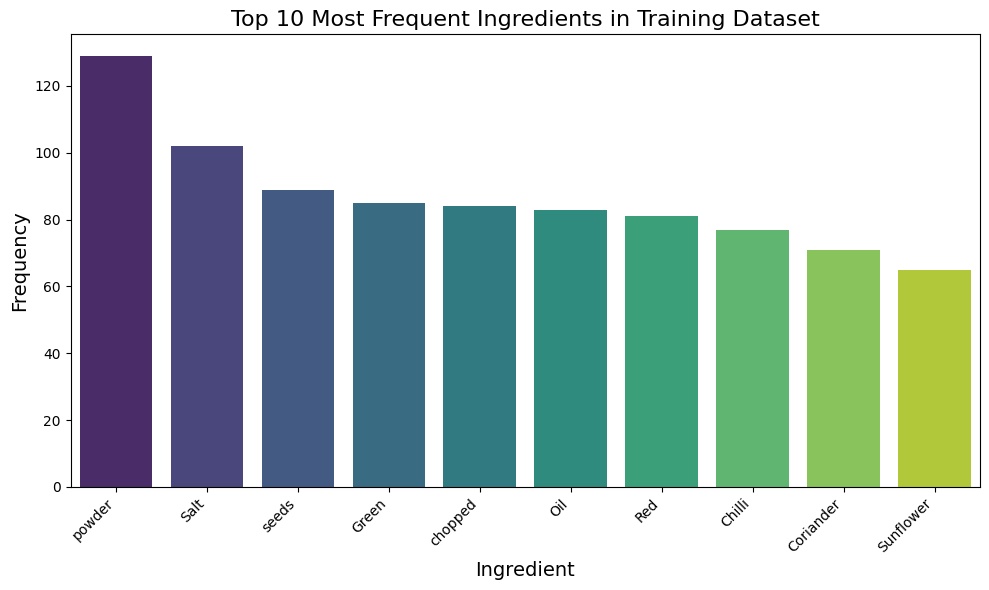

In [ ]:
# plot the top frequent ingredients in training data
# Assuming top_ingredients_train is already defined with the top 10 most frequent ingredients
plot_top_items(top_ingredients_train, "ingredient", "Training")


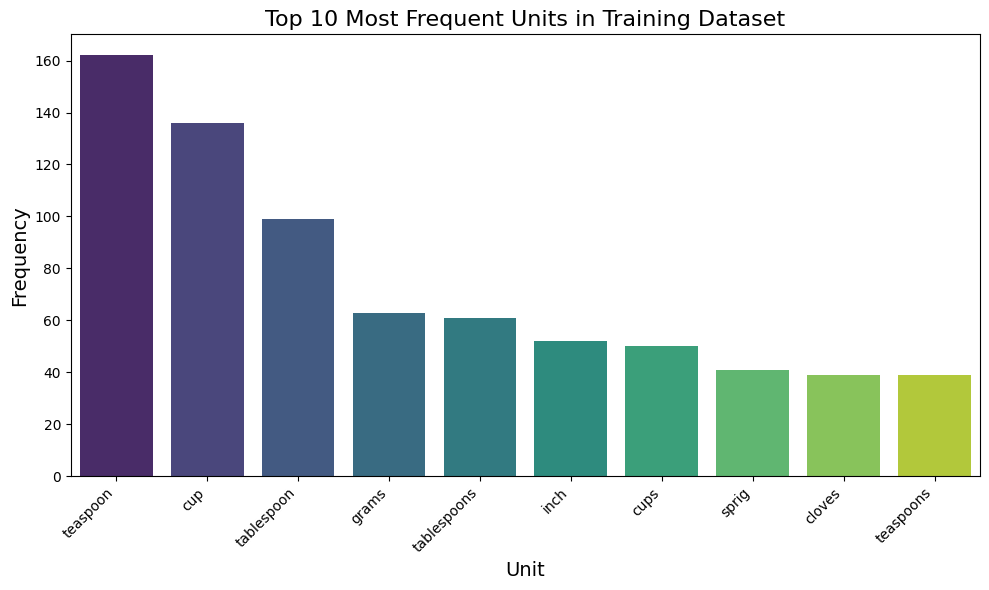

In [ ]:
# plot the top frequent units in training data

plot_top_items(top_units_train, "unit", "Training")


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [ ]:
# define unit and quantity keywords along with quantity pattern
#unit_keywords = {
#    "cup", "cups", "tbsp", "tablespoon", "tsp", "teaspoon", "ml", "milliliter", "milliliters",
#    "liter", "liters", "ounce", "ounces", "pound", "pounds", "gram", "grams", "kilogram",
#    "kilograms", "inch", "inches", "cloves", "pinch", "sprig", "slice", "dash", "bunch",
#    "quart", "quarts", "gallon", "gallons", "litre", "litres", "tablespoons", "teaspoons",
#    "oz", "fl. oz", "g", "kg", "mg", "cm", "milligram", "milligrams"
#}
unit_keywords = set(token.lower() for token in units_train + units_val)

# Define quantity keywords: These are words related to quantities or fractions commonly used in recipes
#quantity_keywords = {
#    "half", "quarter", "third", "one-half", "one-quarter", "one-third", "two-thirds", "one", "two",
#    "three", "four", "five", "six", "seven", "eight", "nine", "ten", "1/2", "1/4", "1/3", "1",
#    "two-and-a-half", "three-and-a-half", "1.5", "1.25", "0.5", "0.25", "1 1/2", "1 1/4", "1 1/3",
#    "two-thirds", "half-and-half", "1-1/2", "1-1/4", "1-1/3", "1/8", "1/16", "1/32", "two-and-a-half"
#}
quantity_keywords = set(token.lower() for token in quantities_train + quantities_val)

# Sample usage of regex for matching fractional values and quantities in the text
quantity_pattern = r"(\d+/\d+|\d+\.\d+|\d+|\bhalf\b|\bquarter\b|\bthird\b|\bone-and-a-half\b|\btwo-and-a-half\b)"

# Testing the regex for some example values
sample_quantity_text = "1/2 cup, 1.5 teaspoons, one-third"
quantities_found = re.findall(quantity_pattern, sample_quantity_text)
print("Quantities found in the sample text:", quantities_found)
print(unit_keywords)
print(quantity_keywords)


Quantities found in the sample text: ['1/2', '1.5', 'third']
{'kg', 'pressed', 'dry', 'teaspoons', 'liter', 'ml', 'raw', 'cloves', 'sprigs', 'thick', 'scoops', 'clove', 'a', 'finely', 'chopped', 'inch', 'into', 'tablespoons', 'whole', 'pinch', 'or', 'cm', 'red', 'medium', 'tablespoon', 'toasted', 'grams', 'bud', 'sprig', 'gram', 'thin', 'cut', 'sliced', 'cold', 'spoon', 'drops', 'stalks', 'for', 'boiled', 'wedges', 'tbsp', 'fistful', 'long', 'diced', 'julienned', 'tsp', 'inches', 'handful', 'to', 'and', 'green', 'small', 'powdered', 'teaspoon', 'cup', 'gms', 'cups'}
{'7-8', '150', '3/4', '4-5', '1/2', '15', '200', '1-1', 'is', '120', 'taste', '1-3/4', '80', '7', '325', 'cloves', '1-1/2', '50', '300', '250', '1.5', '350', 'a', '2-1/2', '12', '1/8', 'finely', '175', '125', '5-6', '20', '160', '600', '6-8', 'pinch', 'little', '100', '1-1/4', '2.5', '2-1/4', '2-5', '2-3', '14', '1/3', '400', '9', 'for', '2', 'few', '1', 'per', '75', '4', 'one', '1/4', '6', '225', '24', 'as', '2/3', '1-2', 

In [ ]:
# load spaCy model
import spacy

# Load spaCy's language model
nlp = spacy.load("en_core_web_sm")



##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [ ]:
# word2features function to extract features for CRF training
def word2features(sent, i, weight=1.0):
    """
    Extract features for a token at index i in a sentence sent,
    optionally including a class-based weight as a feature.
    """
    token = sent[i]
    features = {}

    # Core linguistic features
    features['bias'] = 1.0
    features['token'] = token.text.lower()
    features['lemma'] = token.lemma_.lower()
    features['pos_tag'] = token.pos_
    features['tag'] = token.tag_
    features['dep'] = token.dep_
    features['shape'] = token.shape_
    features['is_stop'] = token.is_stop
    features['is_digit'] = token.is_digit
    features['has_digit'] = any(char.isdigit() for char in token.text)
    features['has_alpha'] = any(char.isalpha() for char in token.text)
    features['hyphenated'] = '-' in token.text
    features['slash_present'] = '/' in token.text
    features['is_title'] = token.text.istitle()
    features['is_upper'] = token.is_upper
    features['is_punct'] = token.is_punct

    # Quantity & unit detection
    features['is_quantity'] = bool(re.match(quantity_pattern, token.text) or token.text.lower() in quantity_keywords)
    features['is_unit'] = token.text.lower() in unit_keywords
    features['is_numeric'] = bool(re.match(quantity_pattern, token.text))
    features['is_fraction'] = bool(re.match(r'^\d+/\d+$', token.text))
    features['is_decimal'] = bool(re.match(r'^\d+\.\d+$', token.text))

    # Contextual clues
    if i > 0:
        prev_token = sent[i - 1]
        features['prev_token'] = prev_token.text.lower()
        features['prev_is_quantity'] = bool(re.match(quantity_pattern, prev_token.text) or prev_token.text.lower() in quantity_keywords)
        features['prev_is_digit'] = prev_token.is_digit
    else:
        features['prev_token'] = '<BOS>'
        features['prev_is_quantity'] = False
        features['prev_is_digit'] = False

    if i < len(sent) - 1:
        next_token = sent[i + 1]
        features['next_token'] = next_token.text.lower()
        features['next_is_unit'] = next_token.text.lower() in unit_keywords
        features['next_is_ingredient'] = not (next_token.text.lower() in unit_keywords or next_token.text.lower() in quantity_keywords)
    else:
        features['next_token'] = '<EOS>'
        features['next_is_unit'] = False
        features['next_is_ingredient'] = False

    features['BOS'] = (i == 0)
    features['EOS'] = (i == len(sent) - 1)

    # ⬇️ Inject class-based weight as a soft influence
    features['class_weight'] = weight

    return features

# Example usage with spaCy
text = "I love cooking with spices like cumin, coriander, and turmeric."
doc = nlp(text)

# Extract features for each token in the sentence
for i in range(len(doc)):
    features = word2features(doc, i)
    print(f"Features for token {doc[i].text}: {features}\n")


Features for token I: {'bias': 1.0, 'token': 'i', 'lemma': 'i', 'pos_tag': 'PRON', 'tag': 'PRP', 'dep': 'nsubj', 'shape': 'X', 'is_stop': True, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': True, 'is_upper': True, 'is_punct': False, 'is_quantity': False, 'is_unit': False, 'is_numeric': False, 'is_fraction': False, 'is_decimal': False, 'prev_token': '<BOS>', 'prev_is_quantity': False, 'prev_is_digit': False, 'next_token': 'love', 'next_is_unit': False, 'next_is_ingredient': True, 'BOS': True, 'EOS': False, 'class_weight': 1.0}

Features for token love: {'bias': 1.0, 'token': 'love', 'lemma': 'love', 'pos_tag': 'VERB', 'tag': 'VBP', 'dep': 'ROOT', 'shape': 'xxxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': False, 'is_numeric': False, 'is_fraction': False,

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [ ]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent, labels=None, class_weights=None):
    """
    Generate feature dictionaries for all tokens in a sentence,
    optionally including class-based weights if labels and class_weights are provided.

    Parameters:
    - sent: List of spaCy tokens (sentence)
    - labels: List of corresponding labels (same length as sent), optional
    - class_weights: Dictionary mapping label → weight, optional

    Returns:
    - List of feature dictionaries, one per token
    """
    features_list = []

    for i in range(len(sent)):
        # Determine weight for this token's label (if available)
        weight = 1.0
        if labels and class_weights:
            weight = class_weights.get(labels[i], 1.0)

        # Extract features with weight influence
        token_features = word2features(sent, i, weight=weight)
        features_list.append(token_features)

    return features_list


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [ ]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = []
X_val_features = []

# Generate features for the training set
for recipe in X_train:
    # Convert each recipe (sentence) into a list of token features
    doc = nlp(" ".join(recipe))  # Join the tokenized words back into a sentence
    features = sent2features(doc)  # Generate features for this recipe
    X_train_features.append(features)  # Store the features in X_train_features

# Generate features for the validation set
for recipe in X_val:
    # Convert each recipe (sentence) into a list of token features
    doc = nlp(" ".join(recipe))  # Join the tokenized words back into a sentence
    features = sent2features(doc)  # Generate features for this recipe
    X_val_features.append(features)  # Store the features in X_val_features

# X_train_features and X_val_features now hold the feature dictionaries for each recipe


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [ ]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels = []
y_val_labels = []

# Convert y_train labels into a flattened list
for recipe_labels in y_train:
    flattened_labels = recipe_labels  # Each recipe_labels corresponds to the labels for a sentence
    y_train_labels.extend(flattened_labels)  # Add the labels to y_train_labels

# Convert y_val labels into a flattened list
for recipe_labels in y_val:
    flattened_labels = recipe_labels  # Each recipe_labels corresponds to the labels for a sentence
    y_val_labels.extend(flattened_labels)  # Add the labels to y_val_labels

# y_train_labels and y_val_labels now hold the flattened label lists


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [ ]:
# print the length of train features and labels
print(f"Length of X_train_features: {len(X_train_features)}")
print(f"Length of y_train_labels: {len(y_train_labels)}")

Length of X_train_features: 196
Length of y_train_labels: 7114


In [ ]:
# print the length of validation features and labels
print(f"Length of X_val_features: {len(X_val_features)}")
print(f"Length of y_val_labels: {len(y_val_labels)}")

Length of X_val_features: 84
Length of y_val_labels: 2876


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [ ]:
# Flatten labels in y_train
# Flatten the y_train_labels (assuming it's a list of lists)
from itertools import chain

# Flatten the labels
y_train_flat = list(chain.from_iterable(y_train_labels))

# Alternatively, you can use list comprehension:
# y_train_flat = [label for sublist in y_train_labels for label in sublist]

# Print the length of flattened y_train labels
print(f"Length of flattened y_train labels: {len(y_train_flat)}")


Length of flattened y_train labels: 64314


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [ ]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# Count the frequencies of labels in y_train_flat
label_counts = Counter(y_train_flat)

# Calculate the total number of samples (i.e., the total number of labels)
total_samples = sum(label_counts.values())

# Print the label counts and total samples
print(f"Label Counts: {label_counts}")
print(f"Total Samples: {total_samples}")


Label Counts: Counter({'n': 12437, 'i': 12437, 'e': 10646, 't': 8094, 'g': 5323, 'r': 5323, 'd': 5323, 'u': 1791, 'q': 980, 'a': 980, 'y': 980})
Total Samples: 64314


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [ ]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# Calculate class weights using the inverse frequency method
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Print the class weights
print(f"Class Weights: {class_weights}")


Class Weights: {'q': 65.62653061224489, 'u': 35.90954773869347, 'a': 65.62653061224489, 'n': 5.171182761116024, 't': 7.945885841363974, 'i': 5.171182761116024, 'y': 65.62653061224489, 'g': 12.082284426075521, 'r': 12.082284426075521, 'e': 6.0411422130377606, 'd': 12.082284426075521}


In [ ]:
# penalise ingredient label
# Penalize the ingredient label by reducing its weight
for label in class_weights:
    if label == 'i':
        class_weights[label] *= 0.5  # or a more aggressive factor like 0.3

print(f"Adjusted Class Weights: {class_weights}")


Adjusted Class Weights: {'q': 65.62653061224489, 'u': 35.90954773869347, 'a': 65.62653061224489, 'n': 5.171182761116024, 't': 7.945885841363974, 'i': 2.585591380558012, 'y': 65.62653061224489, 'g': 12.082284426075521, 'r': 12.082284426075521, 'e': 6.0411422130377606, 'd': 12.082284426075521}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [ ]:
def extract_features_with_class_weights_new(X, y, class_weights):
    """
    Extracts features from tokenized input (X) and corresponding labels (y),
    injecting class-based weights into each token's feature dictionary.

    Parameters:
    - X: List of token lists (each sentence)
    - y: List of label lists (same shape as X)
    - class_weights: Dictionary mapping label → class weight

    Returns:
    - weighted_features: List of feature dictionaries per sentence (with weights)
    - weighted_labels:   List of corresponding labels
    """
    weighted_features = []
    weighted_labels = []

    for tokens, labels in zip(X, y):
        # Create spaCy token objects while preserving alignment
        doc = [nlp.make_doc(tok)[0] for tok in tokens]

        # Extract weighted features with new sent2features()
        features = sent2features(doc, labels=labels, class_weights=class_weights)

        if len(features) != len(labels):
            print(f"❌ Mismatch: {len(features)} features vs {len(labels)} labels")
            continue

        weighted_features.append(features)
        weighted_labels.append(labels)  # actual gold labels, unchanged

    return weighted_features, weighted_labels



##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [ ]:
# Apply manually computed class weights
# Extract features with class weights for the training set
X_train_weighted_features, y_train_weights = extract_features_with_class_weights_new(X_train, y_train, class_weights)

# Extract features with class weights for the validation set
X_val_weighted_features, y_val_weights = extract_features_with_class_weights_new(X_val, y_val, class_weights)

# Print the results to confirm the features
print(f"First 5 Training Features: {X_train_weighted_features[:1]}")
print(f"First 5 Training Weights: {y_train_weights[:1]}")

print(f"First 5 Validation Features: {X_val_weighted_features[:1]}")
print(f"First 5 Validation Weights: {y_val_weights[:1]}")


First 5 Training Features: [[{'bias': 1.0, 'token': '250', 'lemma': '', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'prev_token': '<BOS>', 'prev_is_quantity': False, 'prev_is_digit': False, 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False, 'BOS': True, 'EOS': False, 'class_weight': 1.0}, {'bias': 1.0, 'token': 'grams', 'lemma': '', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'xxxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': True, 'is_numeric': False, 'is_fraction': False, 'is_decimal': False, 'prev_token': '250'

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [ ]:
from sklearn_crfsuite import CRF

crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
crf_model.fit(X_train_weighted_features, y_train_weights)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [ ]:
# evaluate on the training dataset
y_train_pred = crf_model.predict(X_train_weighted_features)
from sklearn_crfsuite.metrics import flat_f1_score

train_f1 = flat_f1_score(y_train_weights, y_train_pred, average='weighted')
print("Training F1 Score:", train_f1)

Training F1 Score: 0.9907107141247193


In [ ]:
# specify the flat classification report by using training data for evaluation
from sklearn_crfsuite.metrics import flat_classification_report

# Predict on training data
y_train_pred = crf_model.predict(X_train_weighted_features)

# Print classification report
report = flat_classification_report(y_train_weights, y_train_pred)
print("🔍 Flat Classification Report (Training Data):\n")
print(report)


🔍 Flat Classification Report (Training Data):

              precision    recall  f1-score   support

  ingredient       0.99      1.00      0.99      5323
    quantity       1.00      0.98      0.99       980
        unit       0.98      0.97      0.97       811

    accuracy                           0.99      7114
   macro avg       0.99      0.98      0.99      7114
weighted avg       0.99      0.99      0.99      7114



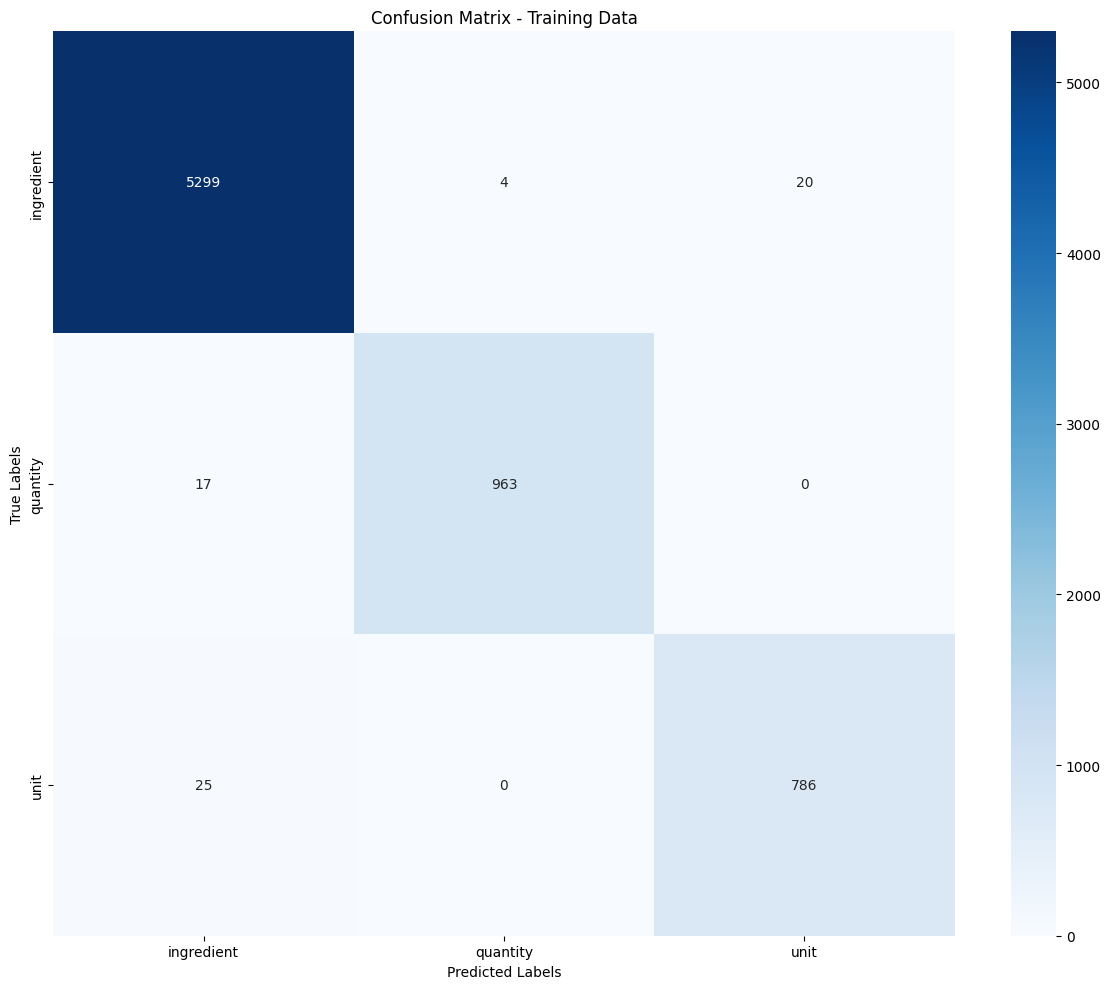

In [ ]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

# Flatten the true and predicted labels
y_train_flat = list(chain.from_iterable(y_train_weights))
y_train_pred_flat = list(chain.from_iterable(y_train_pred))

# Get the sorted list of unique labels
labels = sorted(list(set(y_train_flat + y_train_pred_flat)))

# Create the confusion matrix
cm = confusion_matrix(y_train_flat, y_train_pred_flat, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Training Data")
plt.tight_layout()
plt.show()


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [ ]:
# dump the model using joblib as crf_model.pkl
import joblib

# Save the model to a file
joblib.dump(crf_model, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [ ]:
# predict the crf model on validation dataset
y_val_pred = crf_model.predict(X_val_weighted_features)
from sklearn_crfsuite.metrics import flat_f1_score

val_f1 = flat_f1_score(y_val_weights, y_val_pred, average='weighted')
print("Training F1 Score:", val_f1)

Training F1 Score: 0.9852792783437422


In [ ]:
# specify flat classification report
from sklearn_crfsuite.metrics import flat_classification_report

# Predict on training data
y_val_pred = crf_model.predict(X_val_weighted_features)

# Print classification report
report = flat_classification_report(y_val_weights, y_val_pred)
print("🔍 Flat Classification Report (Training Data):\n")
print(report)

🔍 Flat Classification Report (Training Data):

              precision    recall  f1-score   support

  ingredient       0.99      0.99      0.99      2107
    quantity       0.99      0.99      0.99       411
        unit       0.97      0.93      0.95       358

    accuracy                           0.99      2876
   macro avg       0.98      0.97      0.98      2876
weighted avg       0.99      0.99      0.99      2876



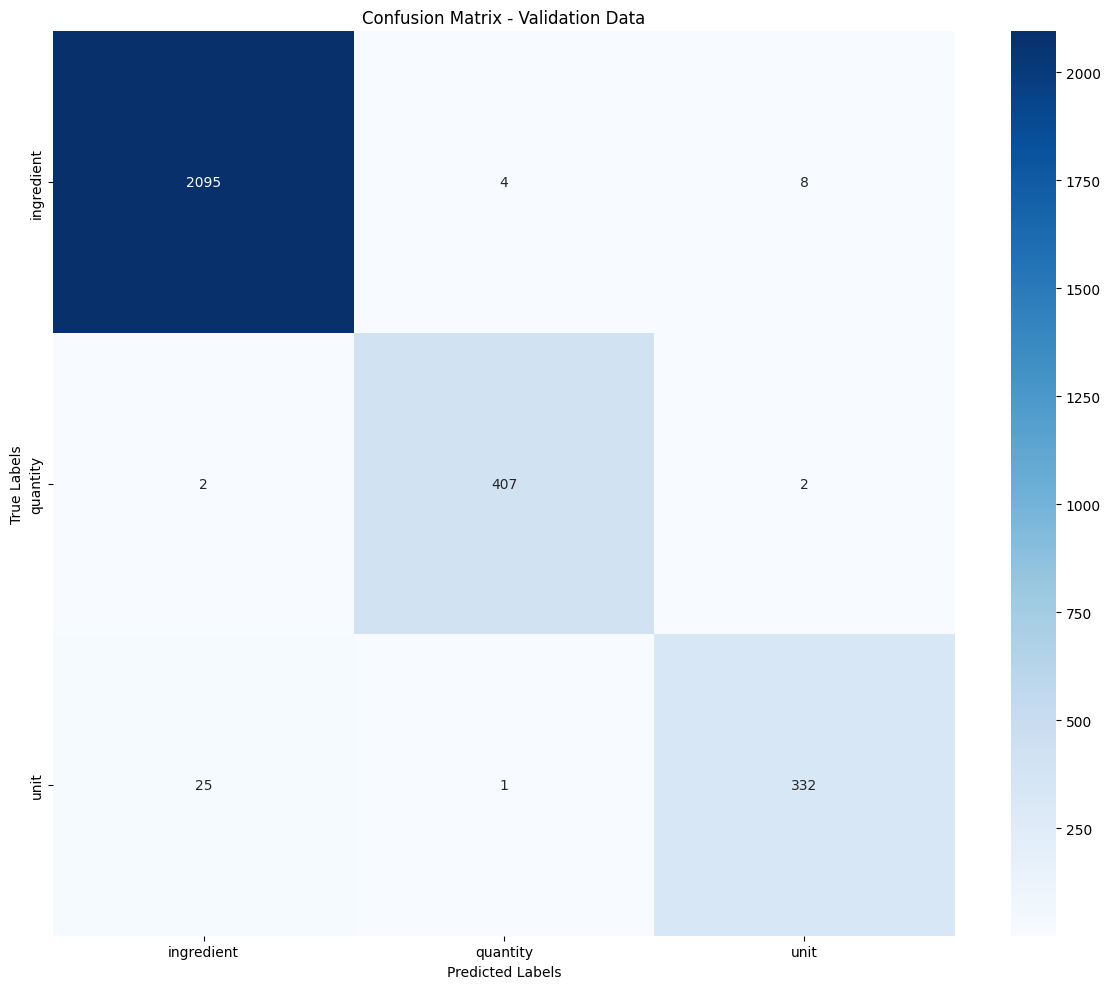

In [ ]:
# create a confusion matrix on validation dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

# Flatten the true and predicted labels
y_val_flat = list(chain.from_iterable(y_val_weights))
y_val_pred_flat = list(chain.from_iterable(y_val_pred))

# Get the sorted list of unique labels
labels = sorted(list(set(y_val_flat + y_val_pred_flat)))

# Create the confusion matrix
cm = confusion_matrix(y_val_flat, y_val_pred_flat, labels=labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Validation Data")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [ ]:
# flatten Labels and Initialise Error Data
from sklearn_crfsuite.metrics import flat_classification_report
import pandas as pd

# Flatten labels for comparison
y_true_flat = [label for sent in y_val_weights for label in sent]
y_pred_flat = [label for sent in y_val_pred for label in sent]

# Flatten input tokens for context
X_val_flat = [token for sent in X_val_weighted_features for token in sent]

# Initialize list to collect error data
error_data = []


In [ ]:
print(X_val_flat[0])

{'bias': 1.0, 'token': '1', 'lemma': '', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': True, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'prev_token': '<BOS>', 'prev_is_quantity': False, 'prev_is_digit': False, 'next_token': 'cup', 'next_is_unit': True, 'next_is_ingredient': False, 'BOS': True, 'EOS': False, 'class_weight': 1.0}


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
for i in range(len(y_true_flat)):
    true_label = y_true_flat[i]
    pred_label = y_pred_flat[i]

    # Only collect errors
    if true_label != pred_label:

        # Extract the token from the 'token' key
        token = X_val_flat[i].get('token', '<UNKNOWN>')  # Fallback to '<UNKNOWN>' if 'token' is missing

        # Extract previous and next tokens with boundary checks
        prev_token = X_val_flat[i - 1].get('token', '<START>') if i > 0 else "<START>"
        next_token = X_val_flat[i + 1].get('token', '<END>') if i < len(X_val_flat) - 1 else "<END>"

        # Optionally, extract the class weight (if relevant)
        weight = X_val_flat[i].get('class_weight', 'N/A')

        # Store error information along with context
        error_data.append({
            'Token': token,
            'Prev_Token': prev_token,
            'Next_Token': next_token,
            'True_Label': true_label,
            'Pred_Label': pred_label,
            'Class_Weight': weight,
            'Context': f"{prev_token} {token} {next_token}"
        })



##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [ ]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

# Calculate overall accuracy
total = len(y_true_flat)
incorrect = len(error_df)
accuracy = (total - incorrect) / total

print(f"✅ Validation Accuracy: {accuracy:.4f}")
print(f"❌ Total Errors: {incorrect}")



✅ Validation Accuracy: 0.9854
❌ Total Errors: 42


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [ ]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
# Errors per true label
error_summary = error_df.groupby('True_Label').agg(
    Total_Errors=('True_Label', 'count'),
    Most_Common_Prediction=('Pred_Label', lambda x: x.mode()[0]),
).reset_index()

print("🔍 Error Summary by True Label:\n")
print(error_summary)

# Show a few sample errors
print("\n📌 Sample Misclassified Tokens:\n")
print(error_df[['Token', 'Prev_Token', 'Next_Token', 'True_Label', 'Pred_Label', 'Context']].head(30))



🔍 Error Summary by True Label:

   True_Label  Total_Errors Most_Common_Prediction
0  ingredient            12                   unit
1    quantity             4             ingredient
2        unit            26             ingredient

📌 Sample Misclassified Tokens:

        Token Prev_Token  Next_Token  True_Label  Pred_Label                      Context
0         few     leaves           1  ingredient    quantity                 leaves few 1
1      cloves          3      garlic  ingredient        unit              3 cloves garlic
2       spoon        big         oil        unit  ingredient                big spoon oil
3          is        pur           2    quantity  ingredient                     pur is 2
4         few     leaves           2  ingredient    quantity                 leaves few 2
5         for        oil    kneading    quantity  ingredient             oil for kneading
6   julienned     ginger  tablespoon        unit  ingredient  ginger julienned tablespoon
7        lo

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = black>[🔍 Insights from the Validation Dataset

The validation accuracy is high at **98.54%,** with a total of **42 errors**.

 Misclassification Trends by Label
Based on the Error Summary by True Label, here’s what we can infer:
The most common error is

1.   **"unit"** predicted as **"ingredient"**
This is the most common error contributing to **60%** of the total errors. The model seems to mislabel units as ingredients frequently.
2.   **"ingredient"** predicted as **"unit"** is the seconf most common error




]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.